


**Security and Privacy in Machine Learning**


**HW3**


**Full Name:** Javad Hezareh

**Student Number:** 98101074

# **Preface (MUST READ :))**
In this notebook you will firstly train a simple CNN and apply the FGSM attack on it to craft adversarial examples, then you wil launch adversaial training on the same CNN architecture, using your method for crafting adversarial examples. Afterwards you will evaluate the  robustness of the defended CNN against PGD attack and then compare the results of this attack on the defended CNN in different settings.

P.S.1 Reminder that the so-called task might be a little bit time consuming even on CUDA! So make sure to start as soon as you can to meet the excercise deadline properly.

P.S.2 It's suggested to save checkpoints for at least every 10 epochs using Colab GPUs.

P.S.3 Don't forget to add the resnet.py file to the same directory of the current notebook on your PC or on Google Drive (if you want to use the drive)

P.S.4 IMPORTANT: In the answers file you will provide at the end for the questions section, you must present a report including the plots and the required values you are asked for, such as the different accuracy values, the success rates and etc for sections 8, 9, 10, 11, 13, 14, 15, 16. the code of these sections is not enough cause the final report will be checked for the values and plots.

P.S.5 BTW Happy New Year :)

# **Training a ResNet18 model with CIFAR10 Dataset**
Use the cells below to  bulid and train a ResNet18 model on CIFAR10 dataset.

# [1] Initial Setups

In [6]:
from google.colab import drive
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from typing import Type
import numpy as np
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from torch.autograd import Variable

# Please use CUDA :\

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device == 'cuda':
    print(torch.cuda.get_device_name(0))

# Let's try Drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/
!mkdir ./SPML-HW3
%cd ./SPML-HW3
!mkdir ./myCIFAR10

# make directories to save checkpoints during training
!mkdir /content/drive/MyDrive/SPML-HW3/ResNet_FGSM/
!mkdir /content/drive/MyDrive/SPML-HW3/ResNet_train/


resnet_url = "https://raw.githubusercontent.com/kuangliu/pytorch-cifar/master/models/resnet.py"
!wget $resnet_url

from resnet import *

cuda
Tesla T4
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive
mkdir: cannot create directory ‘./SPML-HW3’: File exists
/content/drive/MyDrive/SPML-HW3
mkdir: cannot create directory ‘./myCIFAR10’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/SPML-HW3/ResNet_FGSM/’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/SPML-HW3/ResNet_train/’: File exists
--2023-05-02 00:47:29--  https://raw.githubusercontent.com/kuangliu/pytorch-cifar/master/models/resnet.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4218 (4.1K) [text/plain]
Saving to: ‘resnet.py.1’

resnet.py.1         100%[===================>]   4.12K  --.-KB/s 

# [2] CIFAR10 Setup

In [2]:
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(),])

trainset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/SPML-HW3/myCIFAR10', train = True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 2)

testset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/SPML-HW3/myCIFAR10', train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 103013499.14it/s]


Extracting /content/drive/MyDrive/SPML-HW3/myCIFAR10/cifar-10-python.tar.gz to /content/drive/MyDrive/SPML-HW3/myCIFAR10
Files already downloaded and verified


# [3] Training Setup

In [3]:
standard_model = ResNet18()
standard_model = standard_model.to(device)
standard_model.train()

learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(standard_model.parameters(), lr=learning_rate, momentum=0.9)
# Use a scheduler if needed
schedular = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-02.


In [10]:
model_name = "resnet18_cifar10_model_std"
CIFAR10_model_PATH = "/content/drive/MyDrive/SPML-HW3/" + model_name

## uncomment following lines if you have model files
# checkpoint = torch.load(CIFAR10_model_PATH)
# standard_model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['opt_state_dict'])
# schedular.load_state_dict(checkpoint['schedular_state_dict'])

In [11]:
def save_model(model, optimizer, schedular, epoch, path, name):
    model.eval()
    CIFAR10_model_PATH = f'{path}/{name}'
    info = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'opt_state_dict': optimizer.state_dict(),
        'schedular_state_dict': '' if schedular is None else schedular.state_dict()
    }
    torch.save(info, CIFAR10_model_PATH)

In [12]:
def test_model(model, clean=True, adv_model=None, epsilon=8/255):
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        if not clean:
            images = adv_model(images, labels, epsilon)

        outputs = model(images)
        predicted = torch.argmax(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return correct / total

# [4] Train Phase

In [ ]:
save_epoch = 20
save_path = '/content/drive/MyDrive/SPML-HW3/ResNet_train/'
epochs = 20

for epoch in range(epochs):  
    standard_model.train()

    print("epoch " + str(epoch))
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = standard_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1:    # print every 2000 mini-batches #1999
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    
    schedular.step()
    if (epoch+1) % save_epoch == 0:
        save_model(standard_model, optimizer, schedular, save_path, f'resnet_epoch{epoch}.state')
        print(f'model saved in {save_path}!')

print('Finished Training')

epoch 0
[1,     2] loss: 0.002
Adjusting learning rate of group 0 to 1.0000e-02.
epoch 1
[2,     2] loss: 0.001
Adjusting learning rate of group 0 to 1.0000e-02.
epoch 2
[3,     2] loss: 0.001
Adjusting learning rate of group 0 to 1.0000e-02.
epoch 3
[4,     2] loss: 0.000
Adjusting learning rate of group 0 to 1.0000e-02.
epoch 4
[5,     2] loss: 0.000
Adjusting learning rate of group 0 to 1.0000e-02.
epoch 5
[6,     2] loss: 0.000
Adjusting learning rate of group 0 to 1.0000e-02.
epoch 6
[7,     2] loss: 0.000
Adjusting learning rate of group 0 to 1.0000e-02.
epoch 7
[8,     2] loss: 0.000
Adjusting learning rate of group 0 to 1.0000e-02.
epoch 8
[9,     2] loss: 0.000
Adjusting learning rate of group 0 to 1.0000e-02.
epoch 9
[10,     2] loss: 0.000
Adjusting learning rate of group 0 to 9.0000e-03.
epoch 10
[11,     2] loss: 0.000
Adjusting learning rate of group 0 to 9.0000e-03.
epoch 11
[12,     2] loss: 0.000
Adjusting learning rate of group 0 to 9.0000e-03.
epoch 12
[13,     2] lo

# [5] Evaluating Total Standard Accuracy
Check your model accuracy with the following piece of code

In [13]:
standard_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = standard_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Standard Accuracy of ResNet18 model on the 10000 test images: {100 * correct / total} %')

Standard Accuracy of ResNet18 model on the 10000 test images: 84.97 %


# [6] Saving the trained model (Optional)

In [ ]:
standard_model.eval()
model_name = "resnet18_cifar10_model_std"
CIFAR10_model_PATH = "/content/drive/MyDrive/SPML-HW3/" + model_name
info = {
        'epoch': epoch,
        'model_state_dict': standard_model.state_dict(),
        'opt_state_dict': optimizer.state_dict(),
        'schedular_state_dict': schedular.state_dict()
    }
torch.save(info, CIFAR10_model_PATH)

# **Implementing FGSM**

# [7] Fast Gradient Sign Method
You must complete the required sections with proper code for FGSM attack

In [14]:
class FGSMAttack():
    def __init__(self, model):
        self.model = model
        self.adversarials = []
        self.originals = []
        self.predictions = []
        self.confidences = []
        self.truths = []
        self.loss_fn = nn.NLLLoss()

    def untargeted_fgsm(self, image, epsilon, gradient):
        # Define untargeted fast gradient sign attack pertubation
        # Firstly perturb the image in the proper direction then clamp it between the right values.
        #############################
        # Your code goes here
        perturbed = image + epsilon * (1.0 * (gradient > 0) - 1.0 * (gradient < 0))
        return torch.clamp(perturbed, min=0.0, max=1.0)
        #############################

    def __call__(self, image, label, epsilon):
        image = image.to(device)
        label = label.to(device)
        
        image.grad = None
        image.requires_grad = True

        out = self.model(image)
        _, pred = torch.max(out, 1)
        
        loss = self.loss_fn(out, label)
        loss.backward()

        perturbed_image = self.untargeted_fgsm(image, epsilon, image.grad)
        return perturbed_image

# [8] Evaluating FGSM Accuracy of Standard Trained Model

In [15]:
# For 3 values of epsilon = 4/255, 8/255, 12/255
# Launch the FGSM attack,
# Use the whole testloader to generate a set of adversarial examples on the CIFAR10 testset
# Then use this new testset for calculating the adversarial accuracy of the standard target model
#############################
# Your code goes here
fgsm_adversary = FGSMAttack(standard_model)
epsilon_values = [4/255, 8/255, 12/255]
accuracy = [test_model(standard_model, clean=False, adv_model=fgsm_adversary, epsilon=e) for e in epsilon_values]

for (e, acc) in zip(epsilon_values, accuracy):
    print(f'epsilon:{e:.3f},\taccuracy:{acc:.3f}')
#############################

epsilon:0.016,	accuracy:0.100
epsilon:0.031,	accuracy:0.016
epsilon:0.047,	accuracy:0.006


# [9] Crafting Adversarial Examples with FGSM

In [16]:
# Using the epsilon value of 8/255
# For the first 5 adversarial images, 
# Print the true label, the model prediction and the confidence of each prediction for each image
#############################
# Your code goes here
fgsm_adversary = FGSMAttack(standard_model)
logsoftmax = nn.LogSoftmax(dim=1)

epsilon = 8/255

images, labels = next(iter(testloader))
images = images[:5].to(device)
labels = labels[:5].to(device)

perturbed_images = fgsm_adversary(images, labels, epsilon)
out = standard_model(perturbed_images)

logprobs = logsoftmax(out)
log_conf, predicted = torch.max(logprobs, dim=1)
confidencs = torch.exp(log_conf)

for true_label, pred, conf in zip(labels, predicted, confidencs):
    print(f'True Label:\t\t{classes[true_label]}\nPredicted Label:\t{classes[pred]}\nConfidence:\t\t{conf}\n')
#############################

True Label:		cat
Predicted Label:	dog
Confidence:		0.7221257090568542

True Label:		ship
Predicted Label:	car
Confidence:		0.6422818303108215

True Label:		ship
Predicted Label:	bird
Confidence:		0.9973348379135132

True Label:		plane
Predicted Label:	ship
Confidence:		0.9980005621910095

True Label:		frog
Predicted Label:	deer
Confidence:		0.9999992847442627



# [10] Plotting


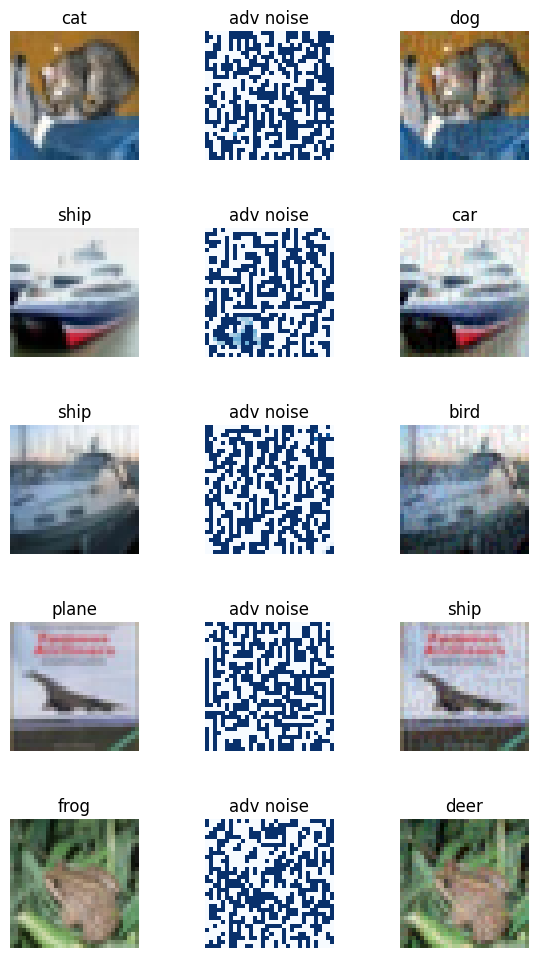

In [17]:
import matplotlib.pyplot as plt
# Now show the 5 original test images mentioned in the previous cell
# And the FGSM perturbation added to each image (with epsilon = 8/255)
# Then the adversarial example created on the same 5 test images using the mentioned FGSM perturbation
#############################
# Your code goes here
fig, axis = plt.subplots(5, 3, figsize=(3*2, 5*2))
fig.tight_layout()

for i in range(5):
    perturbation = perturbed_images - images

    axis[i, 0].imshow(images[i].permute(1, 2, 0).detach().cpu())
    axis[i, 1].imshow(perturbation[i].permute(1, 2, 0)[:,:,0].detach().cpu(), cmap='Reds', alpha=1)
    axis[i, 1].imshow(perturbation[i].permute(1, 2, 0)[:,:,2].detach().cpu(), cmap='Greens', alpha=1)
    axis[i, 1].imshow(perturbation[i].permute(1, 2, 0)[:,:,1].detach().cpu(), cmap='Blues', alpha=1)
    axis[i, 2].imshow(perturbed_images[i].permute(1, 2, 0).detach().cpu())

    axis[i, 0].axis('off')
    axis[i, 1].axis('off')
    axis[i, 2].axis('off')

    axis[i, 0].set_title(classes[labels[i]])
    axis[i, 1].set_title('adv noise')
    axis[i, 2].set_title(classes[predicted[i]])
#############################

# [11] **Adversarial Training**

In [34]:
fgsm_train_losses = []

# define models
fgsm_model = ResNet18().to(device)
fgsm_adversary = FGSMAttack(fgsm_model)

# hyperparameters and optimizer
epsilon = 8/255
learning_rate = 0.01
epochs = 100
save_path = '/content/drive/MyDrive/SPML-HW3/ResNet_FGSM/'
save_epoch = 20
save_iter = 50

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fgsm_model.parameters(), lr=learning_rate, momentum=0.9)

In [37]:
fgsm_model_name = "/content/drive/MyDrive/SPML-HW3/ResNet_FGSM/fgsm_resnet_epoch99.state"

## uncomment following lines if you have model files
# checkpoint = torch.load(fgsm_model_name)
# fgsm_model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['opt_state_dict'])
# fgsm_train_losses = torch.load("/content/drive/MyDrive/SPML-HW3/ResNet_FGSM/loss.ptk")

In [ ]:
# Now train a ResNet model with FGSM adversarial examples crafted on CIFAR10 trainset
# Then report the clean accuracy of this adversarially trained network on the clean CIFAR10 testset
# Also report the adversarial accuracy of this adversarially trained network against FGSM with epsilon = 8/255 on the CIFAR10 testset
# Try using a scheduler for the learning rate (if needed)
#############################
# Your code goes here

# train
for epoch in range(80, epochs):
    fgsm_model.train()
    print("epoch " + str(epoch))
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        adv_inputs = fgsm_adversary(inputs, labels, epsilon)

        optimizer.zero_grad()
        outputs = fgsm_model(adv_inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item() * len(labels)
        if (i+1) % save_iter == 0:    # print every `save_iter` mini-batches
            print(f'[e:{epoch}, i:{i}] loss: {running_loss / save_iter:.3f}')
            fgsm_train_losses.append(running_loss / save_iter)
            running_loss = 0.0
    
    # save state dicts
    if (epoch+1) % save_epoch == 0:
        save_model(fgsm_model, optimizer, None, epoch, save_path, f'fgsm_resnet_epoch{epoch}.state')
        print(f'model saved in {save_path}!')

print('Finished Training')
#############################

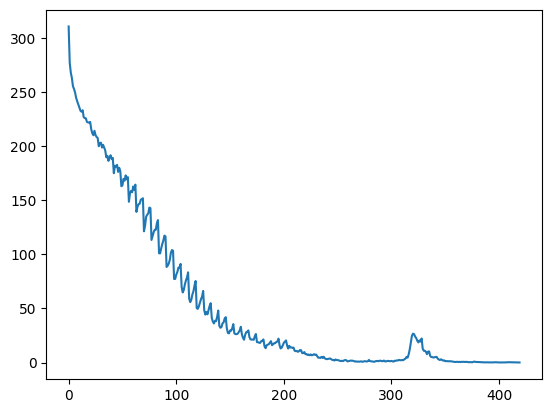

In [21]:
plt.plot(fgsm_train_losses);

In [38]:
fgsm_adversary = FGSMAttack(fgsm_model)
print(f'FGSM-ResNet18 clean accuracy: {100 * test_model(fgsm_model, clean=True)} %')
print(f'FGSM-ResNet18 adversarial accuracy: {100 * test_model(fgsm_model, clean=False, adv_model=fgsm_adversary, epsilon=8/255)} %')

FGSM-ResNet18 clean accuracy: 76.01 %
FGSM-ResNet18 adversarial accuracy: 39.97 %


# **Implementing PGD**

# [12] Projected Gradient Descent
You must complete the required sections with proper code for PGD attack

In [26]:
class LinfPGDAttack(object):
    def __init__(self, model, k = 2, alpha = 2/255):
        self.model = model
        self.steps = k
        self.alpha = alpha
        self.loss_fn = nn.CrossEntropyLoss()

    def __call__(self, image, label, epsilon):
        image = image.to(device)
        label = label.to(device)

        # uniform in (-e, +e)
        perturbed_image = image + (2 * epsilon * torch.rand(image.shape) - epsilon).to(device)
        perturbed_image = torch.clamp(perturbed_image, min=0.0, max=1.0)

        # PGD steps
        for _ in range(self.steps):
            perturbed_image = perturbed_image.detach()
            perturbed_image = perturbed_image.clone()
            perturbed_image.requires_grad = True

            out = self.model(perturbed_image)
            loss = self.loss_fn(out, label)
            loss.backward()

            grad = perturbed_image.grad
            perturbed_image = perturbed_image + self.alpha * (1.0 * (grad > 0) - 1.0 * (grad < 0))
            perturbed_image = torch.clamp(perturbed_image,
                                          min=torch.where((image-epsilon) < 0, 0, image-epsilon),
                                          max=torch.where((image+epsilon) > 1, 1, image+epsilon))

        return perturbed_image

# [13] Evaluating PGD Accuracy of Adversarially Trained Model and Standard Trained Model

In [27]:
# Now launch the attack with the proper inputs for the whole CIFAR10 testset (with epsilon = 8/255)
# on the adversarially trained model and the standard trained model with 2 different step settings: k = 2 and k = 4
# Then print the PGD Accuracy for the images crafted with these 2 settings on the defended model and the standard model

# By PGD Accuracy we mean check if the adversarially trained model could still understand the true label that must be predicted
# Or will the model still get fooled by the PGD attack again after the FGSM adversarial training?
#############################
# Your code goes here
K = [2, 4]
result = {
    'standard_model': [],
    'fgsm_model': []
}

# test models
for k in K:
    pgd_adversary = LinfPGDAttack(standard_model, k=k)
    acc = test_model(standard_model, clean=False, adv_model=pgd_adversary, epsilon=8/255)
    result['standard_model'].append((k, acc))

    pgd_adversary = LinfPGDAttack(fgsm_model, k=k)
    acc = test_model(fgsm_model, clean=False, adv_model=pgd_adversary, epsilon=8/255)
    result['fgsm_model'].append((k, acc))

# print result
for m in result.keys():
    for k, acc in result[m]:
        print(f'{m} accuracy with PGD, k={k}: {100*acc:.3f} %')
############################# 

standard_model accuracy with PGD, k=2: 5.310 %
standard_model accuracy with PGD, k=4: 0.190 %
fgsm_model accuracy with PGD, k=2: 62.960 %
fgsm_model accuracy with PGD, k=4: 58.600 %


# [14] Plotting

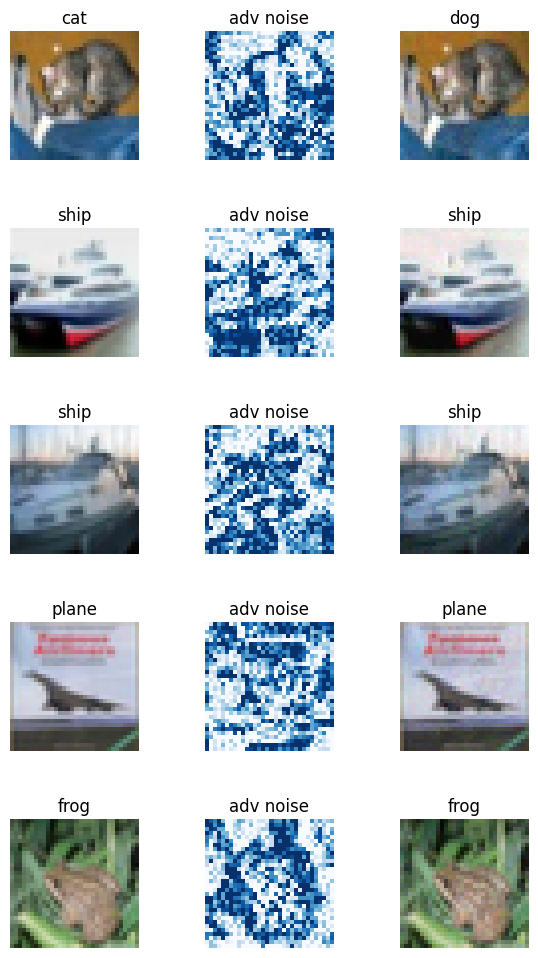

In [33]:
# Now show 5 original test images from the CIFAR10 testset 
# And the PGD perturbation added to each image (with epsilon = 8/255)
# Then the adversarial example created on the same 5 test images using the mentioned PGD perturbation
#############################
# Your code goes here
pgd_adversary = LinfPGDAttack(fgsm_model, k=k)
epsilon = 8/255

images, labels = next(iter(testloader))
images = images[:5].to(device)
labels = labels[:5].to(device)
perturbed_images = pgd_adversary(images, labels, epsilon)
predicted = torch.argmax(fgsm_model(perturbed_images), dim=1)

fig, axis = plt.subplots(5, 3, figsize=(3*2, 5*2))
fig.tight_layout()

for i in range(5):
    perturbation = perturbed_images - images

    axis[i, 0].imshow(images[i].permute(1, 2, 0).detach().cpu())
    axis[i, 1].imshow(perturbation[i].permute(1, 2, 0)[:,:,0].detach().cpu(), cmap='Reds', alpha=1)
    axis[i, 1].imshow(perturbation[i].permute(1, 2, 0)[:,:,2].detach().cpu(), cmap='Greens', alpha=1)
    axis[i, 1].imshow(perturbation[i].permute(1, 2, 0)[:,:,1].detach().cpu(), cmap='Blues', alpha=1)
    axis[i, 2].imshow(perturbed_images[i].permute(1, 2, 0).detach().cpu())

    axis[i, 0].axis('off')
    axis[i, 1].axis('off')
    axis[i, 2].axis('off')

    axis[i, 0].set_title(classes[labels[i]])
    axis[i, 1].set_title('adv noise')
    axis[i, 2].set_title(classes[predicted[i]])
#############################

# [15] Noisy Input Accuracy

In [32]:
# Add Gaussian noise with mean of 0 and variance of 6/255 to the CIFAR10 testset
# Evaluate the accuracy of these noisy images on the standard trained model and the adversarially trained model
# What do you conclude from the results of applying noisy inputs and adversarial example inputs to both of the models?
#############################
# Your code goes here
std_correct = 0
fgsm_correct = 0
total = 0
for data in testloader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    images += torch.randn(images.shape).to(device) * np.sqrt(6/255)

    outputs = standard_model(images)
    predicted = torch.argmax(outputs, 1)
    std_correct += (predicted == labels).sum().item()

    outputs = fgsm_model(images)
    predicted = torch.argmax(outputs, 1)
    fgsm_correct += (predicted == labels).sum().item()
    
    total += labels.size(0)

print(f'Standard Model with noisy input accuracy: {100 * std_correct / total:.3f} %')
print(f'FGSM Model with noisy input accuracy: {100 * fgsm_correct / total:.3f} %')
#############################

Standard Model with noisy input accuracy: 34.210 %
FGSM Model with noisy input accuracy: 73.090 %


# [16] Logit VS Epsilon Test

In [97]:
# Pick the first image x from the CIFAR10 testset
# Make sure the prediction for this image is done correctly by the standard trained model
# Compute the gradient of the model's loss with respect to the image x
# Now for the epsilon values between -0.5 and 0.5 with step size of 0.01 (101 different values),
# Compute x + \epsilon.sign(\nabla_x J(W, x, y))
# Get the logit value for these 101 different images (by logit we mean the softmax input)
# Then plot the logit value vs the epsilon value diagram
# Now choose a random direction instead of \nabla_x J(W, x, y), from the Uniform basis between -1 and 1 for each dimension
# Plot the logit value vs the epsilon value diagram with respect to the new direction
# What is your conclusion based on the results achieved from the two digrams?
#############################
epsilons = torch.linspace(-0.5, 0.5, steps=101)
image, label = next(iter(testloader))
image, label = image[0].to(device).unsqueeze(0), label[0].to(device).unsqueeze(0)
image.requires_grad = True

out = standard_model(image)
predict = torch.argmax(out, dim=1)

print(predict == label)

loss = F.cross_entropy(out, label)
loss.backward()

tensor([True], device='cuda:0')


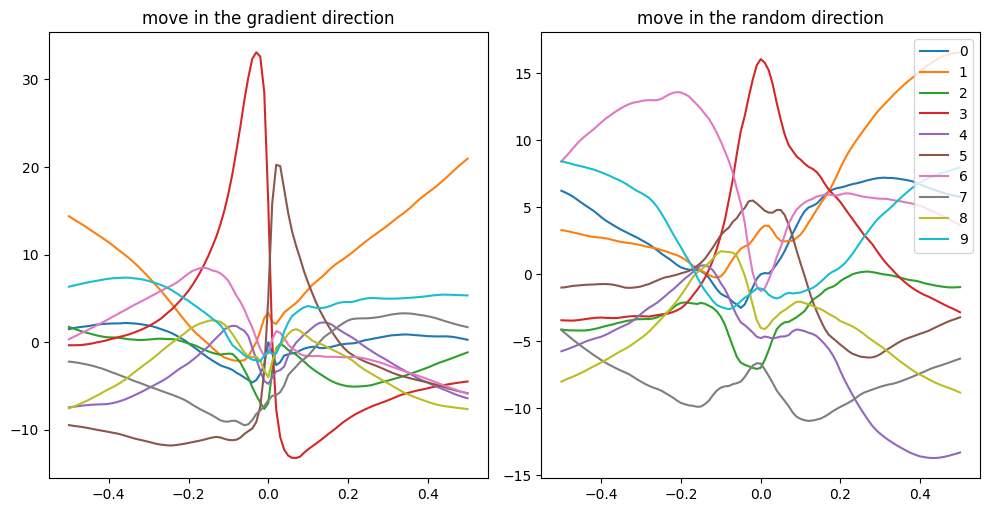

In [98]:
# compute logits for x in the direction of gradient and random direction
grad = image.grad
dir = torch.sign(torch.rand(image.shape) - 0.5).to(device)

grad_logits = torch.cat([standard_model(image + e * torch.sign(grad)) for e in epsilons]).detach().cpu().numpy()
rand_logits = torch.cat([standard_model(image + e * dir) for e in epsilons]).detach().cpu().numpy()

fig, axis = plt.subplots(1, 2, figsize=(5*2, 5*1))
for i in range(10):
    axis[0].plot(epsilons, grad_logits[:, i], label=i)
    axis[1].plot(epsilons, rand_logits[:, i], label=i)
fig.tight_layout()
axis[0].set_title('move in the gradient direction')
axis[1].set_title('move in the random direction')
plt.legend(loc='upper right')
plt.show();